In [10]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use("default")
import os
from itertools import combinations_with_replacement
import time
from src.TOV_class import TOVsolver
from src.plotData import plot_eigs, plot_S, plot_dmd, plot_dmd_rad

In [2]:
# """Script to evaluate DMDs for the TOV equations
# Author: Sudhanva Lalit
# Last edited: 20 September 2024
# """

# import numpy as np
# import os
# import sys
# import json
# from itertools import combinations_with_replacement
# import time
# from TOV_class import TOVsolver
# from plotData import plot_eigs, plot_S, plot_dmd, plot_dmd_rad

# BASE_PATH = os.path.join(os.path.dirname(__file__), "..")
BASE_PATH = "."
EOS_DATA_PATH = f"{BASE_PATH}/EOS_Data/"
EOS_Quarkies = f"{BASE_PATH}/EOS_files/Quarkies/"  # /Quarkies/"
EOS_MSEOS = f"{BASE_PATH}/EOS_files/MSEOS/"
dmdResPath = f"{BASE_PATH}/Results/"
DMD_RES_MSEOS = f"{BASE_PATH}/Results/MSEOS/"
DMD_RES_Quarkies = f"{BASE_PATH}/Results/Quarkies/"
TOV_PATH = f"{BASE_PATH}/TOV_data/"
TOV_MSEOS = f"{BASE_PATH}/TOV_data/MSEOS/"
TOV_Quarkies = f"{BASE_PATH}/TOV_data/Quarkies/"
PLOTS_PATH = f"{BASE_PATH}/Plots/"

p0 = 1.285e3


def augment_data_multiple_columns(X):
    """
    Augment the data matrix X with nonlinear terms for multiple variables.

    Parameters:
    X : np.ndarray
        The data matrix where each row is a variable, and each column is a snapshot in time.

    Returns:
    augmented_X : np.ndarray
        The augmented data matrix with nonlinear terms.
    """
    # Number of variables (rows) and time snapshots (columns)
    n_variables, n_snapshots = X.shape

    # Start with the original variables in the augmented matrix
    augmented_X = X.copy()

    # Add quadratic terms and cross-products
    for i, j in combinations_with_replacement(range(n_variables), 2):
        augmented_term = X[i, :] * X[j, :]
        augmented_X = np.vstack([augmented_X, augmented_term])

    return augmented_X


# Numpy based DMD
def DMD(X, dt):
    """
    Dynamic Mode decomposition for the augmented Data

    Parameters:
    X: np.ndarray
        The data matrix where each row is a variable, and each column is a snapshot in time.
    r: int
        Size of the truncated SVD
    dt: np.float
        Delta T: the time difference of linear DMDs
    """
    n = len(X)

    X = augment_data_multiple_columns(X)
    X1 = np.delete(X, -1, axis=1)
    X2 = np.delete(X, 0, axis=1)
    # print(X.shape, n)

    # Compute SVD of X1
    U, S, Vt = np.linalg.svd(X1, full_matrices=False)
    # print(U.shape)
    
    # Truncate to rank r
    time_initial = time.time()
    r_best = 0
    smallest_total_distance = 100.  # some large number for initialization
    for r in np.arange(1, U.shape[1] + 1):
        print(r)
        U_r = U[:, :r]
        S_r = np.diag(S[:r])
        V_r = Vt[:r, :]
        
        # Compute Atilde
        Atilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(S_r)

        # Compute eigenvectors and eigenvalues
        D, W_r = np.linalg.eig(Atilde)
        
        D_total = np.mean(np.abs(D))
        print(f"D distance = {D_total:.6}")
        
        if D_total < smallest_total_distance:
            r_best = r
            smallest_total_distance = D_total
            print(f"shortest D distance = {smallest_total_distance:.6}")
        print(r_best)
        print("")
        #
    time_final = time.time()
    print(f"eigenvalue search took {time_final - time_initial:.3e} seconds.")
    print(f"Using {r_best} modes.")
    
    U_r = U[:, :r_best]
    S_r = np.diag(S[:r_best])
    V_r = Vt[:r_best, :]
    
    # Compute Atilde
    Atilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(S_r)

    # Compute eigenvectors and eigenvalues
    D, W_r = np.linalg.eig(Atilde)
    
    # Phi = U_r @ W_r

    Phi = X2 @ V_r.T @ np.linalg.inv(S_r) @ W_r  # DMD modes
    lambda_vals = D  # discrete-time eigenvalues
    omega = np.log(lambda_vals) / dt  # continuous-time eigenvalue

    # Compute DMD mode amplitudes b
    x1 = X1[:, 0]
    b = np.linalg.lstsq(Phi, x1, rcond=None)[0]
    print(b)

    # DMD reconstruction
    mm1 = X1.shape[1] + 1  # mm1 = m - 1
    time_dynamics = np.zeros((r_best, mm1), dtype=complex)
    t = np.arange(mm1) * dt  # time vector

    # time dynamics upto a given time.
    for iter in range(mm1):
        time_dynamics[:, iter] = b * np.exp(omega * t[iter])

    # Finally collect the DMDs upto rank n.
    Xdmd2 = Phi @ time_dynamics
    Xdmd = Xdmd2[:n, :]
    Phi = Phi[:n, :]

    return Phi, omega, lambda_vals, b, Xdmd, S


def solve_tov(fileName, tidal=False, parametric=False, mseos=True):
    r"""
    Solves the TOV equation and returns radius, mass and central pressure

    Parameters:
        fileName (str): Filename containing the EOS in the format nb (fm^-3),
            E (MeV), P (MeV/fm^3)

    Returns:
        dataArray (array): Data array containing radii, central pressure
            and mass.
    """
    if parametric is False:
        eos_file = EOS_DATA_PATH + fileName
        global TOV_PATH
    else:
        if mseos is True:
            eos_file = EOS_MSEOS + fileName
            TOV_PATH = TOV_MSEOS
        else:
            eos_file = EOS_Quarkies + fileName
            TOV_PATH = TOV_Quarkies
    if not os.path.exists(TOV_PATH):
        os.makedirs(TOV_PATH)

    # Replace the filename and run the code
    file = TOVsolver(eos_file, tidal=tidal)
    file.tov_routine(verbose=False, write_to_file=False)
    print("R of 1.4 solar mass star: ", file.canonical_NS_radius())
    dataArray = [
        file.total_radius.flatten(),
        file.total_pres_central.flatten(),
        file.total_mass.flatten(),
    ]
    if tidal is True:
        dataArray.append(file.k2.flatten())
        # dataArray.append(file.tidal_deformability.flatten()[::-1])

    dataArray = np.asarray(dataArray, dtype=np.float64)
    name = (fileName.split(".")[0].split("_eos")[0])
    file = "MR_" + name + ".dat"
    np.savetxt(TOV_PATH + file, dataArray.T, fmt="%1.8e")
    return dataArray


In [3]:
fileName = "../EOS_files/Quarkies/EOS_Quarkyonia_300.00_0.10.dat"

In [4]:
startHFTime = time.time()
radius, pcentral, mass, tidal_def = solve_tov(fileName, True, False, False)
endHFTime = time.time()

p = pcentral
r = radius
m = mass
linT = np.arange(len(p))
X = [np.log(r), np.log(p), np.log(m)]
X.append(np.log(tidal_def))


Woo it worked!
Max mass:  3.025518750164877 Radius:  15.026376561499996 Central pressure:  203.685969621747
R of 1.4 solar mass star:  14.294246965290418


1
D distance = 1.01737
shortest D distance = 1.01737
1

2
D distance = 0.966654
shortest D distance = 0.966654
2

3
D distance = 0.971261
2

4
D distance = 0.967886
2

5
D distance = 0.964627
shortest D distance = 0.964627
5

6
D distance = 1.0058
5

7
D distance = 1.00508
5

8
D distance = 0.993051
5

9
D distance = 0.962153
shortest D distance = 0.962153
9

10
D distance = 0.878607
shortest D distance = 0.878607
10

11
D distance = 0.823344
shortest D distance = 0.823344
11

12
D distance = 0.843377
11

13
D distance = 0.807012
shortest D distance = 0.807012
13

14
D distance = 0.829835
13

eigenvalue search took 2.447e-03 seconds.
Using 13 modes.
[-7.11322866e-02+2.15733317e-14j -5.37964669e-01+1.21386909e-12j
  1.32119033e-02+1.43587751e-14j -7.58801558e-01-2.30748869e-15j
  2.20709988e+00-8.42900665e-14j  2.47816012e-02+3.87977865e-14j
 -1.24108374e+01+3.58630774e+00j -1.24108374e+01-3.58630774e+00j
 -6.17526764e+01-1.09194401e-13j  2.52276124e+01-1.06018457e+02j
  2.52276124e+01+

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_64223/24352144.py:99: RuntimeWarning: overflow encountered in exp
  rad_DMD = np.exp(Xdmd[0].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_64223/24352144.py:100: RuntimeWarning: overflow encountered in exp
  pres_DMD = np.exp(Xdmd[1].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_64223/24352144.py:102: RuntimeWarning: overflow encountered in exp
  k2_DMD = np.exp(Xdmd[3].real)


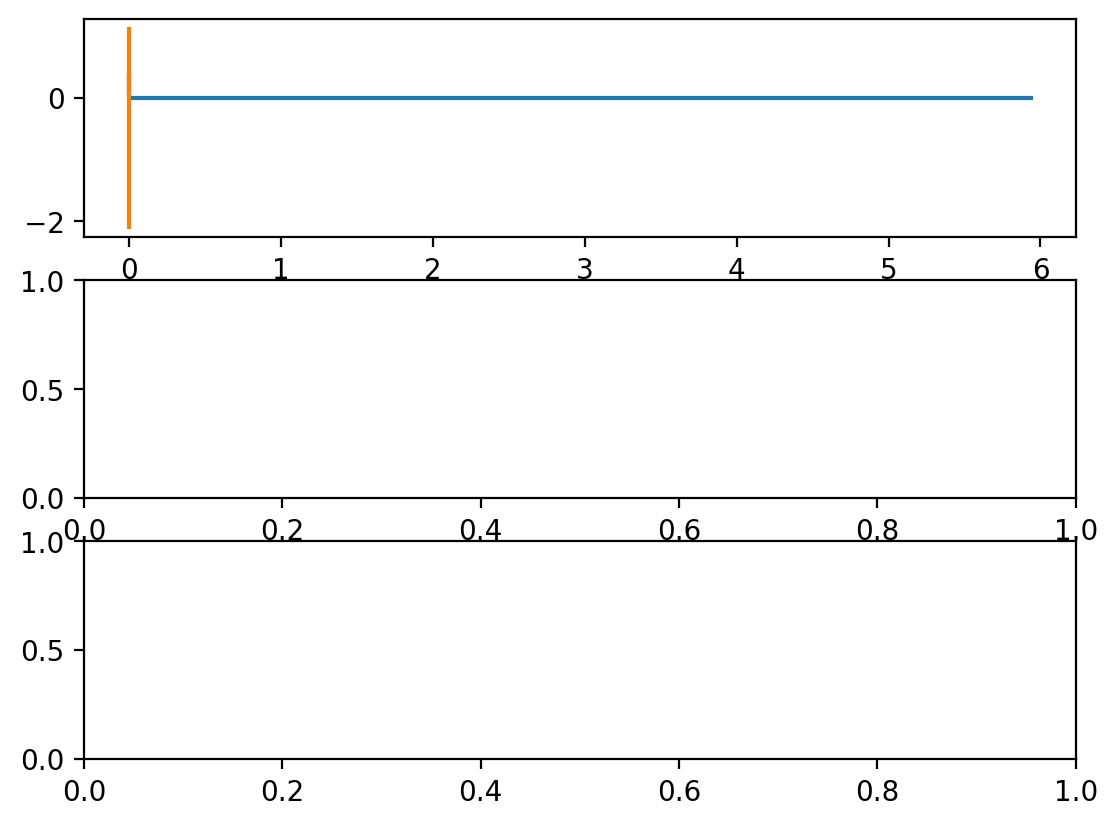

In [11]:
X = np.asarray(X, dtype=np.float64)
# print("X shape: ", X)
startDMDTime = time.time()

def DMD(X, dt):
    """
    Dynamic Mode decomposition for the augmented Data

    Parameters:
    X: np.ndarray
        The data matrix where each row is a variable, and each column is a snapshot in time.
    r: int
        Size of the truncated SVD
    dt: np.float
        Delta T: the time difference of linear DMDs
    """
    n = len(X)

    X = augment_data_multiple_columns(X)
    X1 = np.delete(X, -1, axis=1)
    X2 = np.delete(X, 0, axis=1)
    # print(X.shape, n)

    # Compute SVD of X1
    U, S, Vt = np.linalg.svd(X1, full_matrices=False)
    # print(U.shape)
    
    # Truncate to rank r
    time_initial = time.time()
    r_best = 0
    smallest_total_distance = 100.  # some large number for initialization
    for r in np.arange(1, U.shape[1] + 1):
        print(r)
        U_r = U[:, :r]
        S_r = np.diag(S[:r])
        V_r = Vt[:r, :]
        
        # Compute Atilde
        Atilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(S_r)

        # Compute eigenvectors and eigenvalues
        D, W_r = np.linalg.eig(Atilde)
        
        D_total = np.mean(np.abs(D))
        print(f"D distance = {D_total:.6}")
        
        if D_total < smallest_total_distance:
            r_best = r
            smallest_total_distance = D_total
            print(f"shortest D distance = {smallest_total_distance:.6}")
        print(r_best)
        print("")
        #
    time_final = time.time()
    print(f"eigenvalue search took {time_final - time_initial:.3e} seconds.")
    print(f"Using {r_best} modes.")
    
    U_r = U[:, :r_best]
    S_r = np.diag(S[:r_best])
    V_r = Vt[:r_best, :]
    
    # Compute Atilde
    Atilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(S_r)

    # Compute eigenvectors and eigenvalues
    D, W_r = np.linalg.eig(Atilde)
    
    # Phi = U_r @ W_r

    Phi = X2 @ V_r.T @ np.linalg.inv(S_r) @ W_r  # DMD modes
    lambda_vals = D  # discrete-time eigenvalues
    omega = np.log(lambda_vals) / dt  # continuous-time eigenvalue

    # Compute DMD mode amplitudes b
    x1 = X1[:, 0]
    b = np.linalg.lstsq(Phi, x1, rcond=None)[0]
    print(b)

    # DMD reconstruction
    mm1 = X1.shape[1] + 1  # mm1 = m - 1
    time_dynamics = np.zeros((r_best, mm1), dtype=complex)
    t = np.arange(mm1) * dt  # time vector

    # time dynamics upto a given time.
    for iter in range(mm1):
        time_dynamics[:, iter] = b * np.exp(omega * t[iter])

    # Finally collect the DMDs upto rank n.
    Xdmd2 = Phi @ time_dynamics
    Xdmd = Xdmd2[:n, :]
    Phi = Phi[:n, :]

    return Phi, omega, lambda_vals, b, Xdmd, S

phi, omega, lam, b, Xdmd, S = DMD(X, (linT[-1] - linT[0]) / len(linT))

endDMDTime = time.time()

rad_DMD = np.exp(Xdmd[0].real)
pres_DMD = np.exp(Xdmd[1].real)
mass_DMD = np.exp(Xdmd[2].real)
k2_DMD = np.exp(Xdmd[3].real)

fig, ax = plt.subplots(3, 1, dpi=200)
ax[0].plot(rad_DMD, mass_DMD)
ax[0].plot(X[0], X[2])

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_64223/2073837649.py:1: RuntimeWarning: overflow encountered in exp
  rad_DMD = np.exp(Xdmd[0].real)
/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_64223/2073837649.py:2: RuntimeWarning: overflow encountered in exp
  pres_DMD = np.exp(Xdmd[1].real)
/Users/joshuamaldonado/Documents/GitHub/SLM/src/plotData.py:200: RuntimeWarning: overflow encountered in exp
  ax.plot(t, np.exp(Xdmd[i].real), label="DMD")
/Users/joshuamaldonado/Documents/GitHub/SLM/src/plotData.py:246: RuntimeWarning: overflow encountered in exp
  ax.plot(np.exp(Xdmd[0].real), np.exp(Xdmd[i + 1].real), label="DMD")


DMD Maximum mass: 0.38560015776859585; maximum radius: 14.043943058058106


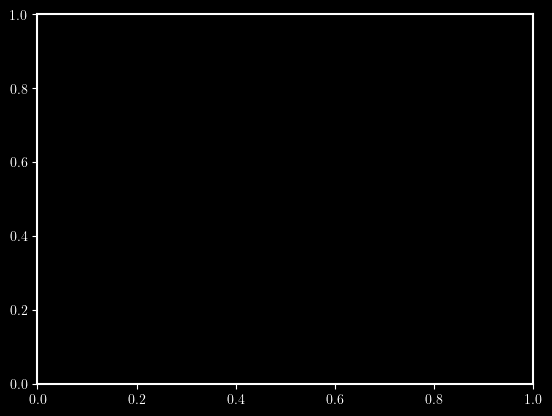

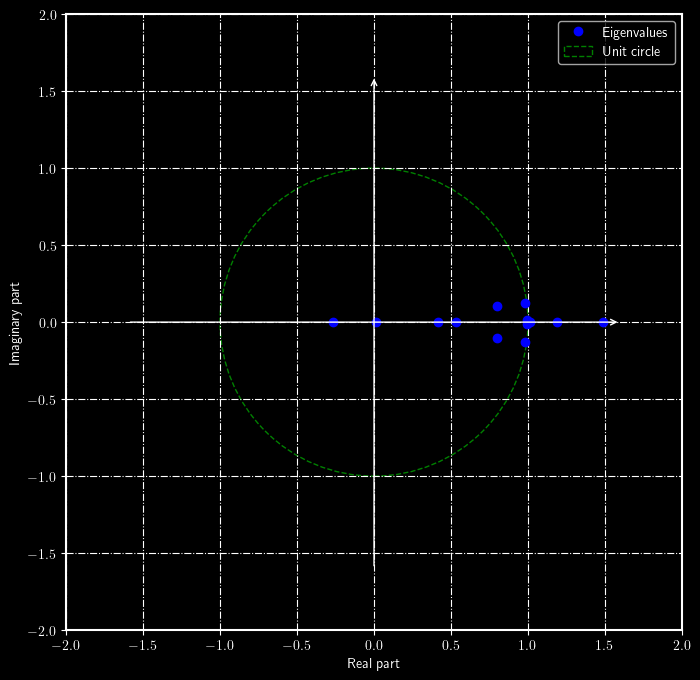

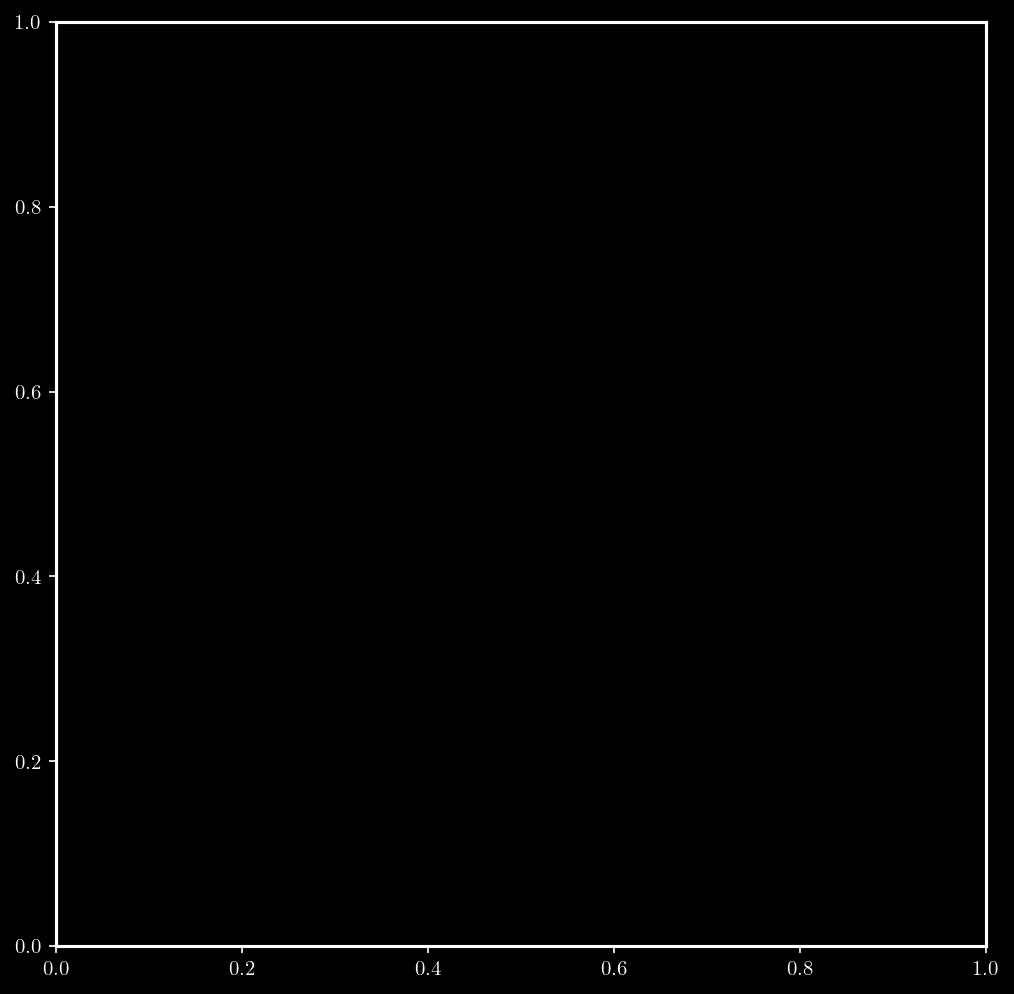

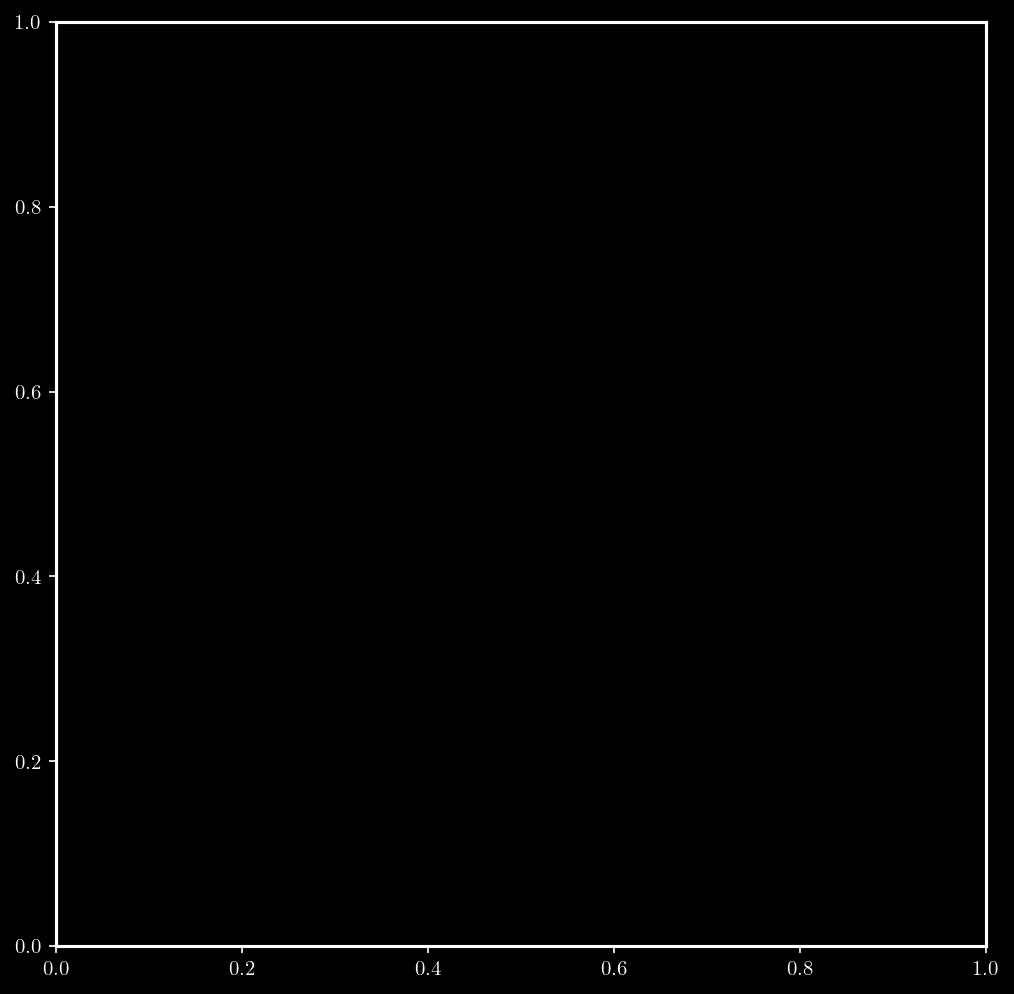

In [6]:
rad_DMD = np.exp(Xdmd[0].real)
pres_DMD = np.exp(Xdmd[1].real)
mass_DMD = np.exp(Xdmd[2].real)

# Make plots
# Plot the S values
plot_S(S)

# Plot the eigenvalues
plot_eigs(lam, filename="eigenValues.pdf")

# Plot the DMDs
fileNames = ["radiusDMD.png", "pressureDMD.png", "massDMD.png"]
ylabels = ["Radius (km) ", r"Pressure $(MeV/fm^3)$", r"Mass $M_{(\odot)}$"]
fileNames.append("tidalDMD.png")
ylabels.append(r"$\Lambda$")
plot_dmd(linT, X, Xdmd, fileNames, ylabels, fileName)
# Plot Mass vs Radius
ylabels = [r"Pressure $(MeV/fm^3)$", r"Mass $M_{(\odot)}$"]
newFiles = ["pressure_radius.png", "mass_radius.png"]
ylabels.append(r"$k_2$")
newFiles.append("tidal_radius.png")
plot_dmd_rad(X, Xdmd, newFiles, ylabels, fileName)

# maximum values
max_mass_DMD = np.max(mass_DMD)
max_index = np.where([mass_DMD[i] == max_mass_DMD for i in range(len(mass_DMD))])[0][0]
max_radius_DMD = rad_DMD[max_index]

print(
    "DMD Maximum mass: {}; maximum radius: {}".format(max_mass_DMD, max_radius_DMD)
)
HFTime = endHFTime - startHFTime
DMDTime = endDMDTime - startDMDTime

